# Zillow Data Time Series Analysis

### Contributors: Sanjit Varma, Anthony Conte, Harmandip Singh

In [1]:
#Importing necessary Packages
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import folium
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline

#Custom Helper Function to melt Time Series Data
import tools.helpers as th

# Business Understanding

&emsp; Our client is looking to purchase a home in the Miami-Dade county after recently accepting a job offer in the area. The client has established that they are not looking to spend over $300,000. They also specified that their current job offer is a 3 year contract and therefore there is a reasonable possibility that they may have to relocate after 3 years. 

&emsp; Therefore, they have approached us to identify neighborhoods that have average prices under their budget which would also give them the highest return on investment if they were to sell their property upon relocation in 3 years. Our task is to identify the best 5 Zip Codes which we believe will have the highest ROI after 3 years of purchase. i.e. We want the zipcodes that we believe will appreciate the most in value after 3 years. These predictions will be made using Time Series modeling. 

# Data Understanding

Let us import our data and took a look at the dataset we get to work with.

In [2]:
#Loading our dataset
df = pd.read_csv('data/zillow_data.csv')

In [3]:
#Observing what our dataset looks like
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


Since our client wants to move to Miami-Dade County, let us filter this dataframe to only include records within the specified region.

## Looking at our Miami-Dade County data

In [4]:
#Dataframe containing only zips from Miami-Dade County

miami_dade =  df[df['CountyName']=='Miami-Dade']

In [5]:
#Observing what our Miami-Dade dataset looks like

miami_dade.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
60,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0,337900.0,338300.0,...,1466200,1471000,1485400,1497700,1504200,1507600,1495800,1466200,1443900,1432300
84,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0,480700.0,481200.0,...,2917100,2925700,2942400,2958300,2946300,2912900,2900900,2923300,2933600,2914100
222,72488,33186,The Crossings,FL,Miami-Fort Lauderdale,Miami-Dade,223,120600.0,120500.0,120500.0,...,310600,311800,313700,314800,315300,317500,320700,322800,323900,324500
226,72350,33012,Hialeah,FL,Miami-Fort Lauderdale,Miami-Dade,227,118400.0,118500.0,118500.0,...,300300,302100,304500,306400,307200,308900,311400,314100,317500,320500
376,72460,33157,Village of Palmetto Bay,FL,Miami-Fort Lauderdale,Miami-Dade,377,106400.0,106600.0,106800.0,...,295600,298300,301600,304400,305900,307500,309700,312500,316400,319800
496,72353,33015,Country Club,FL,Miami-Fort Lauderdale,Miami-Dade,497,114100.0,114200.0,114300.0,...,316200,319300,322800,326100,328100,330100,333100,334900,335200,335300
512,72444,33141,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,513,179500.0,179900.0,180300.0,...,817100,837600,847000,843600,838500,836400,839800,838400,833400,830900
766,72478,33176,Kendall,FL,Miami-Fort Lauderdale,Miami-Dade,767,164800.0,165000.0,165000.0,...,458700,459900,462300,464900,465800,466100,467400,470000,473500,476100
831,72480,33178,Doral,FL,Miami-Fort Lauderdale,Miami-Dade,832,165100.0,165300.0,165400.0,...,409000,407500,406100,404400,401700,400000,399500,399800,401500,403500
838,72428,33125,Miami,FL,Miami-Fort Lauderdale,Miami-Dade,839,98700.0,98700.0,98700.0,...,266400,267200,267800,268000,269000,270800,272400,275100,279700,282900


We can see from the above dataframe that the County area is divided into smaller cities within it. And some City regions like 'Miami Beach' seem to be further divided into different zipcode regions.

## Cities located within the Miami-Dade County region

Let's take a look at the number of cities present within Miami-Dade county and get an understanding of how they are divided into zipcodes respectively.

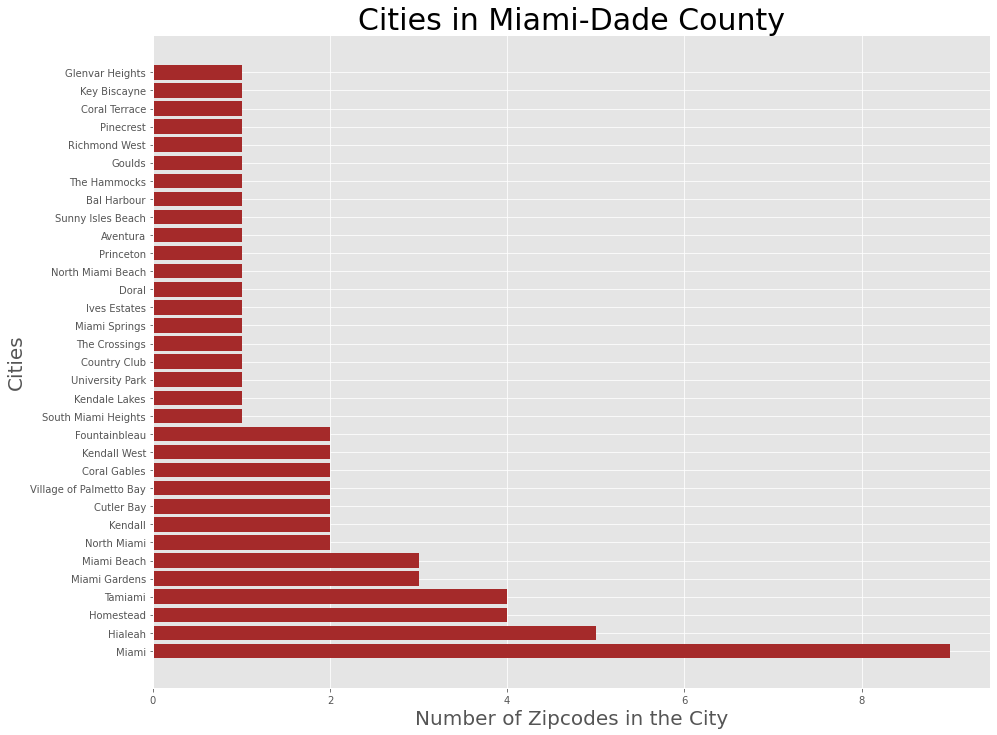

In [6]:
#Visualizing the value counts of zipcodes in each city in the Miami-Dade county

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in miami_dade['City'].value_counts()]

x = [a for a in miami_dade['City'].value_counts().keys()]

ax.barh(x,y,color='brown')
ax.set_title('Cities in Miami-Dade County',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zipcodes in the City',fontsize=20);

We can see above that the city of Miami is divided into the highest number of zipcodes.

Now that we have some understanding of our how the Miami-Dade county is divided, we can now narrow our focus based on our client's requirement.

# Data Preparation

## Filtering for Client's Budget Limit

Since our client has a budget of under 300,000 Dollars we only want to look at zipcodes that fall underneath that price ceiling.

In [7]:
#miami_budget is a dataframe of Miami-Dade County with zipcodes having an average price under $300000 as of April, 2018.
miami_budget = miami_dade[miami_dade['2018-04']<=300000]

In [8]:
#List of Zip Codes in the Miami-Fort Lauderdale metro region within client's budget.
miami_budget_zips = [a for a in miami_budget['RegionName']]

We have filtered Miami-Dade to only include zipcodes having under $300000 in average home value. Let's now take a look at how many cities and zipcodes we are left with.

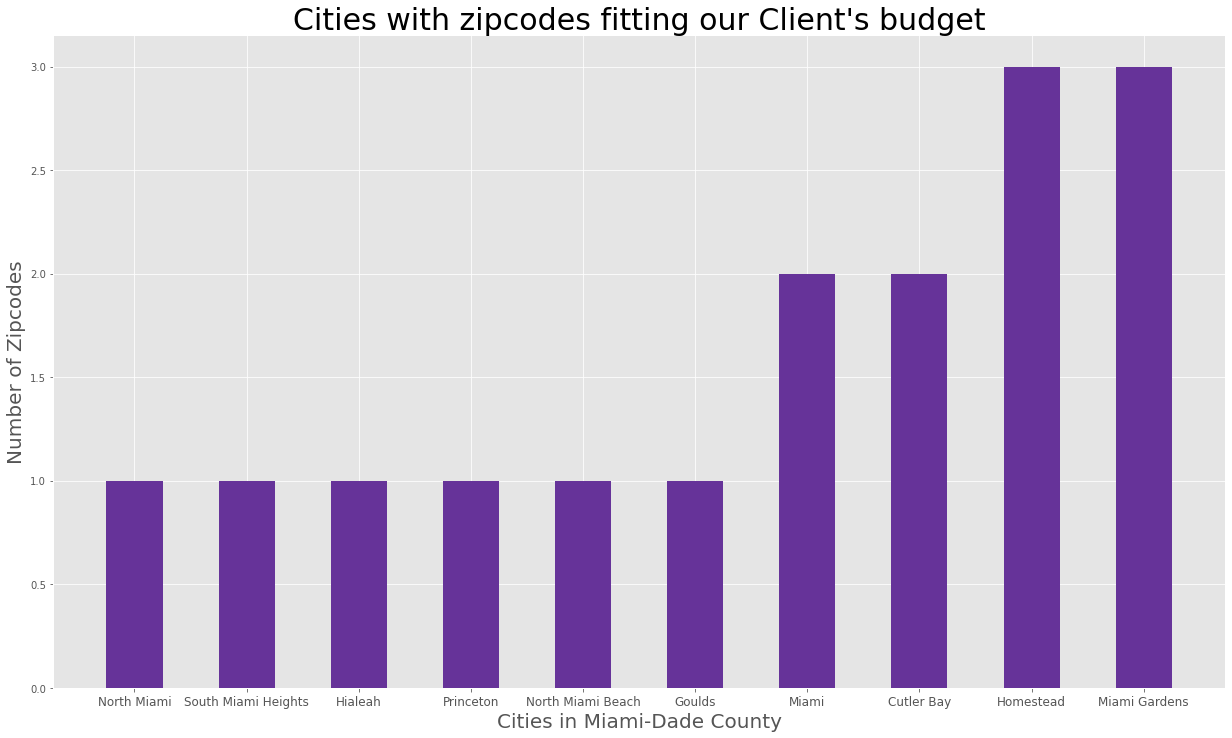

In [9]:
#Pulling necessary data from the dataframe for the bar chart

#Getting City Names
city_names = []

for zipcode in miami_budget_zips:
    city_names.append(miami_budget[miami_budget['RegionName']==zipcode].iloc[0]['City'])

#Retrieving number of zipcodes for each city and feeding it to count_dict
count_dict = {}
for a in Counter(city_names).keys():
    count_dict[a] = Counter(city_names)[a]

#sorting dictionary into ascending order
count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1]))

#Building the bar chart
fig,ax = plt.subplots(figsize=(21,12))

x_labels = [a for a in count_dict.keys()]
x = list(range(1,len(x_labels)+1))
y = [a for a in count_dict.values()]

ax.bar(x,y,color='rebeccapurple',width=0.5)

ax.set_xticks(x)
ax.set_xticklabels(x_labels,fontsize='12')
ax.set_title("Cities with zipcodes fitting our Client's budget",fontsize='30')
ax.set_ylabel("Number of Zipcodes",fontsize='20')
ax.set_xlabel("Cities in Miami-Dade County",fontsize='20');

This chart above gives us useful information about what areas are available for our client under their budget constraints.

## Visualizing the Price history of filtered Zip Codes since 1996

The Visualization below is only for zipcodes that we have filtered under our price limit. Naturally, as a result of this filter we expect all these zipcodes' lates price values to be below $300000.

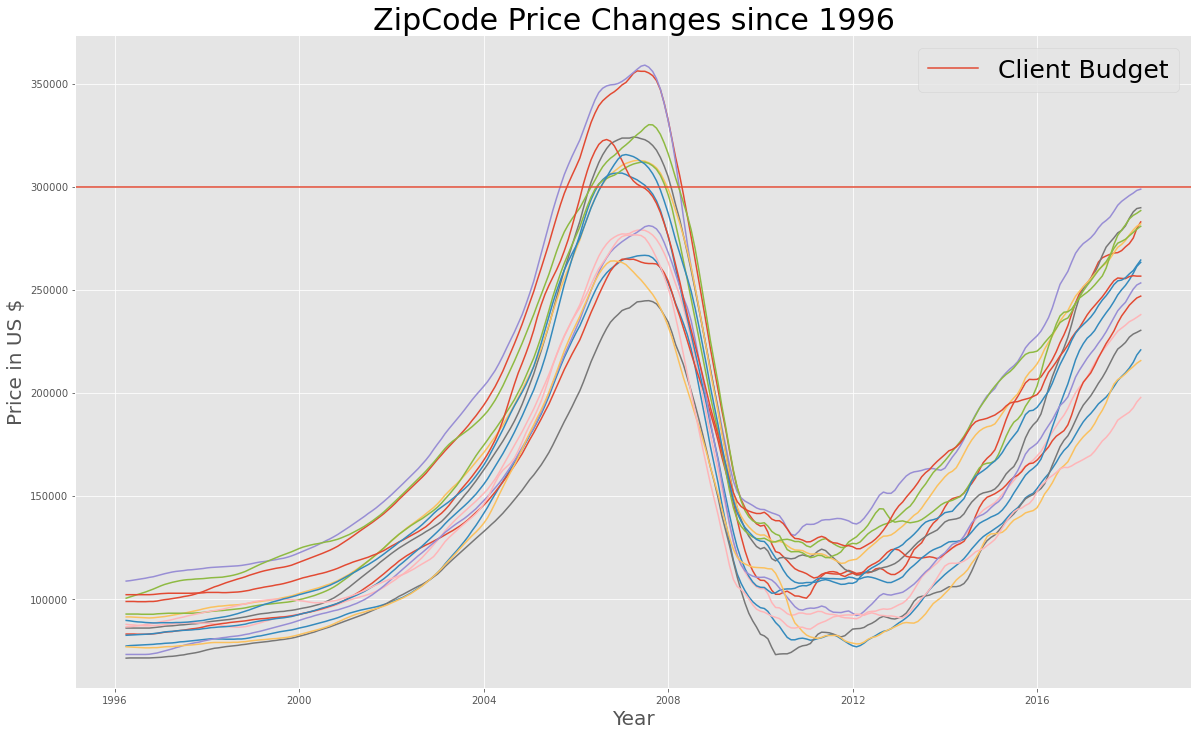

In [10]:
zip_dict = {}

for zipcode in miami_budget_zips:
    zip_dict[zipcode] = th.melt_data(miami_budget[miami_budget['RegionName']==zipcode])

fig,ax = plt.subplots(figsize=(20,12))

for zipcode in zip_dict:
    ax.plot(zip_dict[zipcode],)

ax.axhline(y=300000,label = 'Client Budget')   

ax.set_title('ZipCode Price Changes since 1996',fontsize=30)
ax.set_ylabel('Price in US $',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.legend(prop={'size': 25});

Prices seem to have peaked before the 2008 recession, only to see a dramatic fall immediately after. Since then, prices have been steadily on the rise since 2011 but have yet to reach their pre-recession peaks.

## Visualizing the The Zip Codes' Average Price Growth since 2011

We saw above that prices have started to pick up after the recession; but we want to see more clearly which zipcode areas have been growing the fastest since. Below we can look at a graph that shows us the zipcodes by order of highest growth.

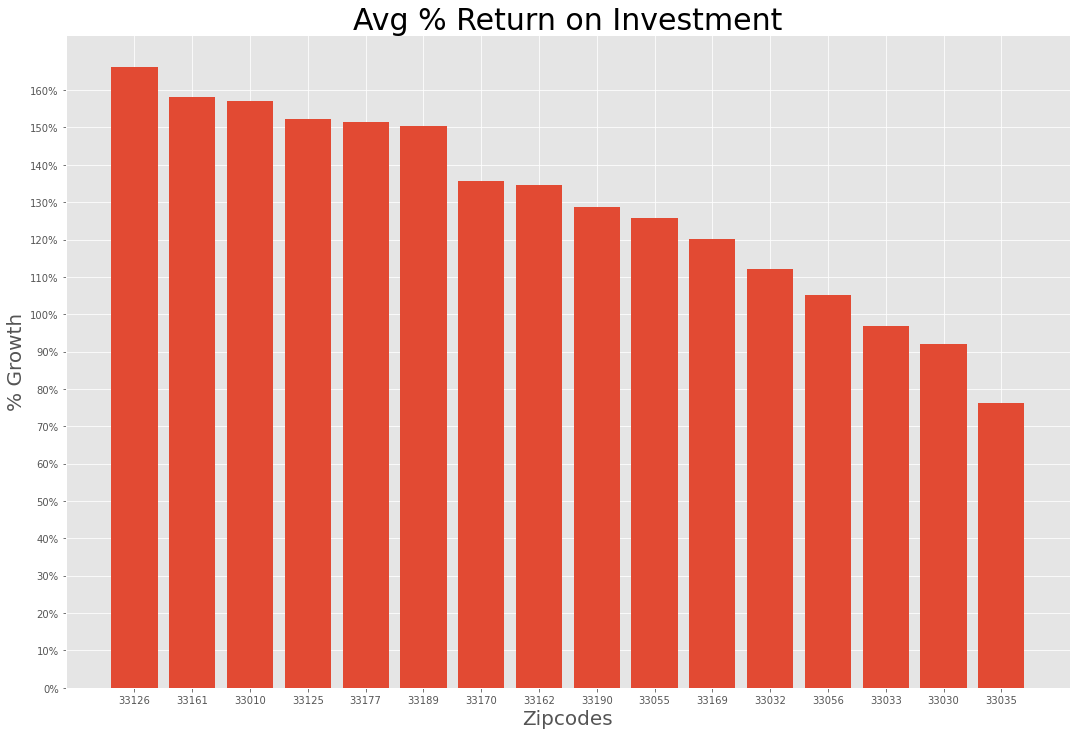

In [11]:
warnings.filterwarnings('ignore')

miami_2011_roi = miami_budget
miami_2011_roi['roi_since11'] = None
miami_2011_roi['roi_since11'] = miami_2011_roi['2018-04'].apply(lambda x : ((x-miami_2011_roi['2011-01'])/(miami_2011_roi['2011-01'])))
miami_2011_roi = miami_2011_roi.sort_values('roi_since11',ascending=False)


fig,ax=plt.subplots(figsize=(18,12))

x_labels = [str(a) for a in miami_2011_roi['RegionName']]
x = list(range(1,17))
y = [a for a in miami_2011_roi['roi_since11']]

ax.bar(x,y)

ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([a/10 for a in list(range(0,17,1))])
ax.set_yticklabels([str(a*10)+'%' for a in list(range(0,17,1))])
ax.set_ylabel('% Growth',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on Investment',fontsize='30');


We can see from the above visual that the highest growing zip code since 2011 is 33126.

## Selecting a ZipCode to build our Time Series model on

We want to build a Time Series model to predict the future ROI for each zip code in Miami-Dade County that would fit our client's budget. But first, we will select one specific zipcode to build our time series model on. For this purpose, we decided to use the highest growing zipcode since 2011.

Therefore, we will run our first Time Series model on the ZipCode- 33126 to predict what its future value will be. Then we can implement a similar workflow on other zipcodes in the County to identify which 5 zipcodes have the highest predicted ROI.

In [12]:
#Dataframe containining historical prices of the 33126 Zip Code.

zip33126 = df[df['RegionName']==33126]

In [13]:
# Time Series dataframe of 33126 Zip Code prices

series33126 = th.melt_data(zip33126)

In [14]:
#Observing our Time Series dataframe

series33126

,value
time,
1996-04-01,108600.0
1996-05-01,108800.0
1996-06-01,109100.0
1996-07-01,109400.0
1996-08-01,109700.0
...,...
2017-12-01,294300.0
2018-01-01,295700.0
2018-02-01,296900.0


We have taken a look at the price history of various zipcodes earlier. Let's now look at the overall average price history of our selected zip-code individually.

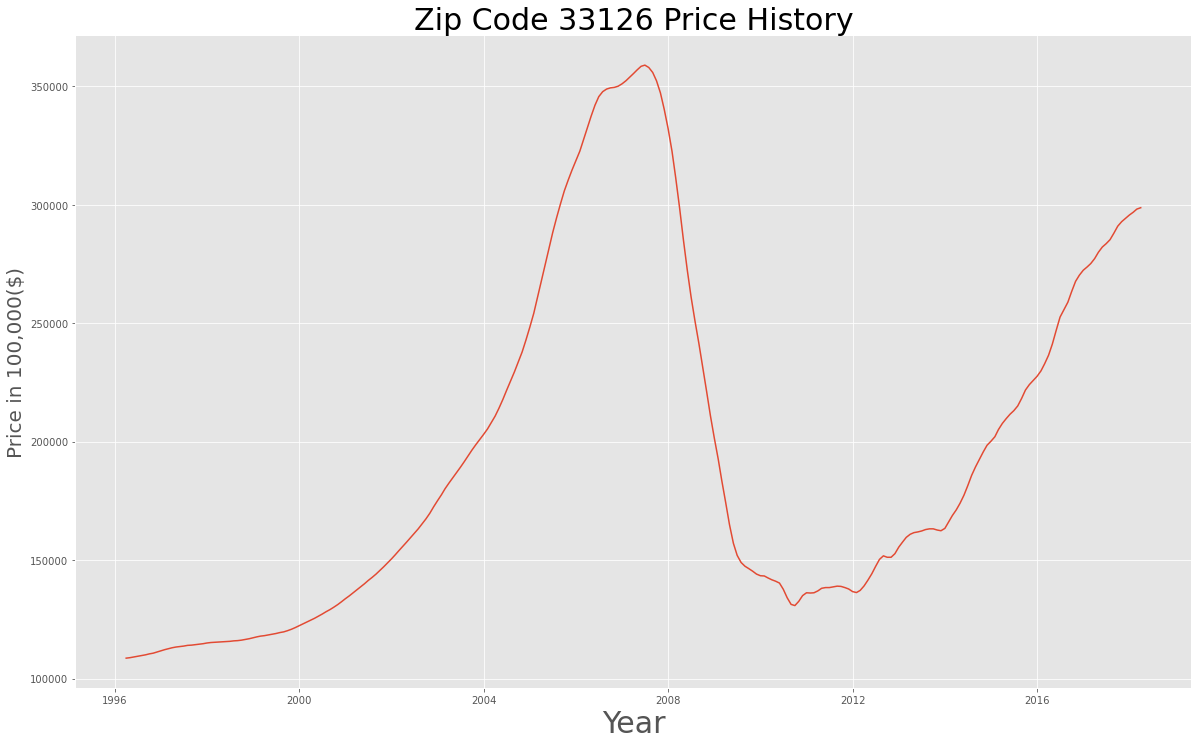

In [15]:
#Visualizing our Time Series Data for zipcode- 33126

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(series33126)

ax.set_xlabel('Year', fontsize=30)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 33126 Price History',fontsize=30);

The trend we see above is not greatly dissimilar to all the other zip codes we saw earlier during our earlier data exploration.

## Relevance of Recent Data

We find that market conditions before the 2010s do not necessarily reflect the state of today's market. Therefore we chose to concentrate on modeling our Time Series only based on information from 2011.

In [16]:
recent_series = series33126['2011':]

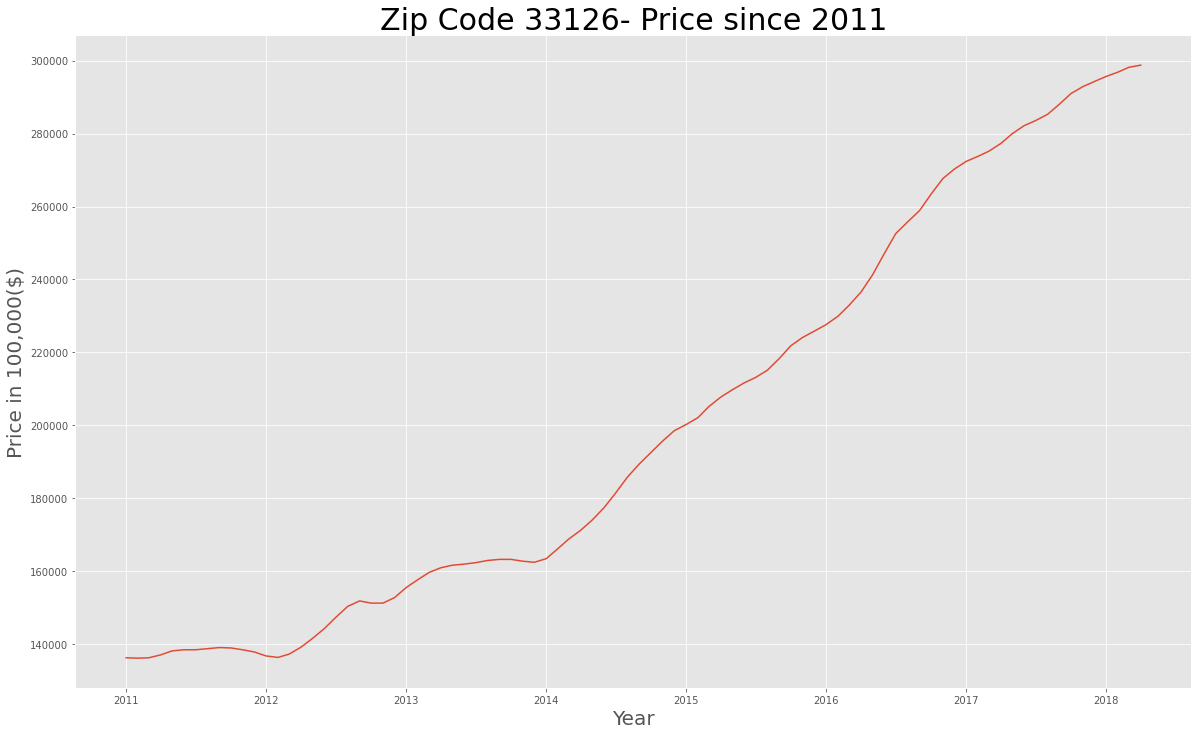

In [17]:
#Visualizing our Time Series Data for zipcode- 33126 from 2011

fig, ax = plt.subplots(figsize=(20,12))
ax.plot(recent_series)

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Price in 100,000($)',fontsize=20)
ax.set_title('Zip Code 33126- Price since 2011',fontsize=30);

We can now see a positive trend that displays a somewhat linear growth rate in average price.

# Model Training and Testing

Because our model of choice performs the preprocessing step of trend/seasonality removal by itself, we will simply input the raw series into our model.

## Splitting our data into Train and Test

In [18]:
# Splitting the last 24 months of our series as a test dataset.
train_series = recent_series[:'2016-04']
test_series = recent_series['2016-05':]

## Fitting an AUTO-ARIMA Model on our Training Series

We find that finding the optimal p,d & q values and then fitting an ARIMA model can be a time consuming approach especially if we want to iterate this process over multiple zip codes. The benefit of using an AUTO-ARIMA model over an ARIMA model is that it helps eliminate the additional step of finding the optimal combination of p,d & q values and thereby it runs faster than an ARIMA model. The AUTO-ARIMA model performs this step for us and plugs in the p,d & q value combination that returns the lowest AIC score.

In [19]:
# In order for this cell to run, you may need to install pmdarima if you haven't already.
import pmdarima as pm

auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1728.368, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1687.033, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1680.709, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1681.812, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1035.278, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1684.647, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 3.665 seco

In [20]:
#Identifying the order values for our model
auto_model.order

(1, 0, 3)

In [21]:
#Identifying the Seasonal Order values for our model
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0102      0.002    461.500      0.000       1.006       1.015
ma.L1          1.5669      0.173      9.055      0.000       1.228       1.906
ma.L2          1.1230      0.252      4.453      0.000       0.629       1.617
ma.L3          0.2647      0.172      1.539      0.124      -0.072       0.602
sigma2      3.637e+05    1.4e-07   2.59e+12      0.000    3.64e+05    3.64e+05


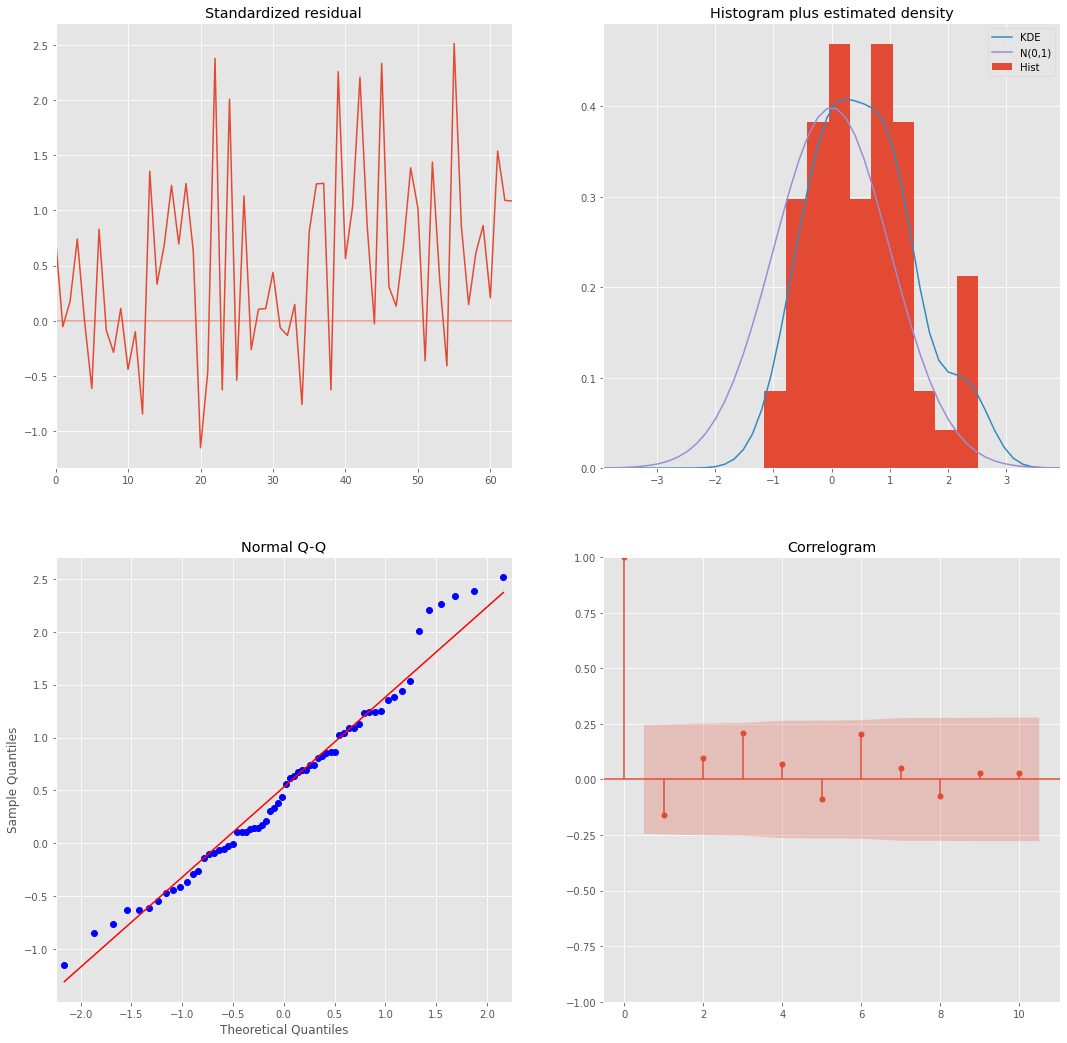

In [22]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train_series, 
                                        order=(1,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

We want to make sure that our residuals are not correlated, and they should have a normal distribution. Otherwise, we need to make further changes to our model.

Let's check for these assumptions from diagnostics plots.


* In the plot on the top-right, our KDE line somewhat closely follows along the N(0,1) line which is the standard notation for a normal distribution having a mean of 0 and standard deviation of 1. This tells us that the residuals are normally distributed.

* Our qq-plot shown on the bottom left displays that our residuals are following the linear trend line. This tells us that the residuals seen here are normally distributed.

* From the Correlogram plot on the bottom left, we see that the time series residuals diaplay low correlations with their lagged versions. This is clearer as we move further along the time series. This tells us there isn't obvious seasonality in our series.

Based on these observations, we can be confident that the model does not have correlations and that it satisfactorily fits our data to forecast future prices.

## Testing our model performance

Let's retrieve our model's predictions for the period between May, 2016 and April 2018; the same period that was used for our test data. We can plot them on the same chart to see how far/close they are from each other.

In [23]:
# Get predictions starting from 04-01-2015 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-05'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower value,upper value
2016-05-01,238782.632383,241146.759996
2016-06-01,239622.132300,246157.519806
2016-07-01,239976.013011,250945.571581
2016-08-01,240711.164686,255239.776193
2016-09-01,241802.432446,259229.389089
2016-10-01,243104.595623,263060.158789
2016-11-01,244554.245181,266796.027590
2016-12-01,246117.059965,270471.855371
2017-01-01,247772.062175,274109.164176
2017-02-01,249505.376021,277722.379611


Now that we have received predictions for our training data, let us plot it against our test data.

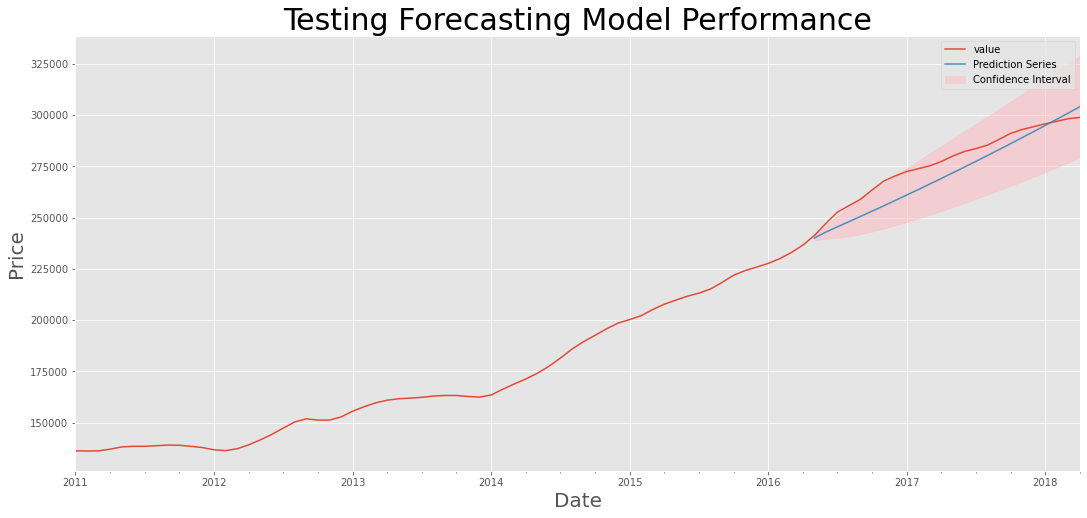

In [24]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 18, 8

# Plot observed values
ax = recent_series.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Prediction Series', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightpink', alpha=0.5,label = 'Confidence Interval')

# Set axes labels
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Price',fontsize=20)
ax.set_title('Testing Forecasting Model Performance',fontsize=30)
plt.legend()

plt.show()

Our model was not perfectly accurate but it was able to capture the overall trend that truly occurred between April, 2016 and April, 2018. Now that we see that we have a model that can perform well over a 2-3 year period, we can move on to forecast the future until April, 2021- the point at which we will have reached 3 years from the purchase date of April, 2018.

# Forecasting the Future

In [25]:
# Plug the parameter values from our Auto ARIMA model into a new SARIMAX model that fits the entire series.
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                        order=(1,0,3), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0102      0.002    461.500      0.000       1.006       1.015
ma.L1          1.5669      0.173      9.055      0.000       1.228       1.906
ma.L2          1.1230      0.252      4.453      0.000       0.629       1.617
ma.L3          0.2647      0.172      1.539      0.124      -0.072       0.602
sigma2      3.637e+05    1.4e-07   2.59e+12      0.000    3.64e+05    3.64e+05


In [26]:
## Getting a forecast for the next 36 months after the last recorded date on our dataset.
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2018-05-01,297721.944672,300613.616330,299167.780501
2018-06-01,296339.248869,304476.173375,300407.711122
2018-07-01,296072.591251,309687.100707,302879.845979
2018-08-01,296711.291695,314640.398360,305675.845028
2018-09-01,297772.973115,319222.336898,308497.655007
2018-10-01,299085.123575,323605.904799,311345.514187
2018-11-01,300571.576440,327867.749637,314219.663038
2018-12-01,302190.836061,332049.852440,317120.344251
2019-01-01,303917.415661,336178.189848,320047.802755
2019-02-01,305734.385318,340270.186166,323002.285742


Now that we have our 3 year forecast, let's visualize it to see how far we expect the 33126 zipcode region to grow by April, 2021.

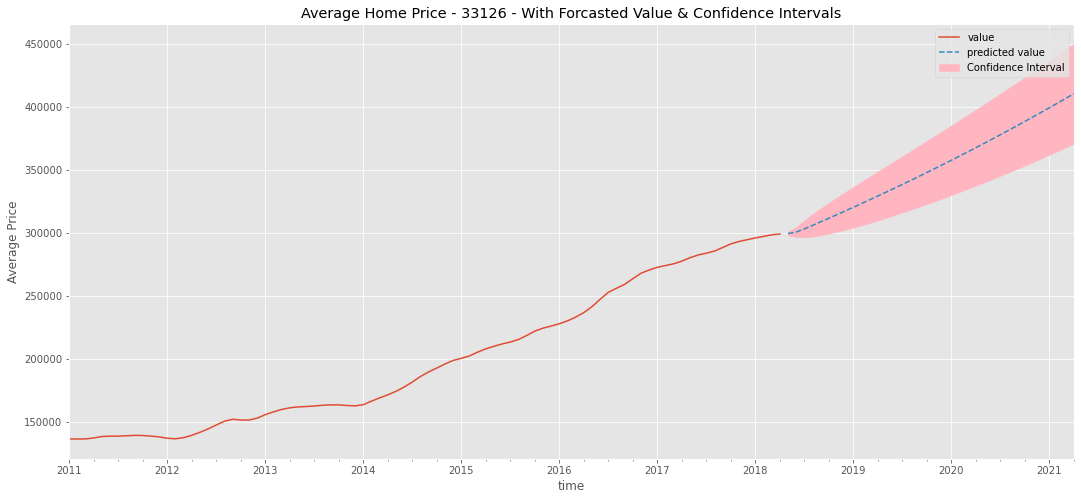

In [27]:
#Plotting our Forecast

fig, ax = plt.subplots()
recent_series.plot(ax=ax,label='Real Values')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightpink',
                label='Confidence Interval')
ax.legend() 
plt.ylabel("Average Price")
plt.title('Average Home Price - 33126 - With Forcasted Value & Confidence Intervals')
plt.show()

Having established a workflow for forecasting future prices for one zipcode, we can now plug in this entire process into a loop to attain our expected prices in April, 2021 for the remaining zipcodes in Miami-Dade County that have average prices under our clients' budget.

# Forecasting on every Zip Code in Miami-Dade within Client Budget

In [28]:
zip_predictions = {}

#miami_budget_zips is a list of zipcodes in Miami-Dade County with average price under $300000
for zipcode in miami_budget_zips:
    
    #Melting the time series of our given zipcode
    series = th.melt_data(df[df['RegionName']== zipcode])
    
    #Only taking data from 2011 onwards to more accurately reflect current market conditions
    recent_series = series['2011':]
    
    # Splitting the last 36 months of our series as a test dataset.
    train_series = recent_series[:'2016-04']
    test_series = recent_series['2016-05':]
    
    #Auto ARIMA model
    auto_model = pm.auto_arima(train_series, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
   
    # Plug the optimal parameter values for our Training data into a SARIMAX model that fits our entire series.
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(recent_series, 
                                            order= auto_model.order, 
                                            seasonal_order= auto_model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    ## Getting a forecast for the next 36 months after the last absrecorded date on our dataset.
    forecast = output.get_forecast(36)
    prediction = forecast.conf_int()
    prediction['value'] = forecast.predicted_mean
    prediction.columns = ['lower','upper','prediction'] 
    
    #Adding the Zipcode's ROI to the zip_predictions dictionary
    zip_predictions[zipcode] = ((prediction['prediction'][-1])
                                - (series['value'][-1]))/ (series['value'][-1])
    

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1707.388, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1666.227, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1660.104, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1661.342, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1038.249, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1034.440, Time=0.48 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1664.355, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1667.878, Time=0.13 sec
 ARIMA(2,0,5)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 A

 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1647.511, Time=0.08 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 3.122 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1689.082, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1647.358, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1640.382, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1640.648, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1009.325, Time=0.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.40 

# Recommendations

Having received all our forecasts, lets identify our Top 5 Zipcodes and see how they compare against each other.

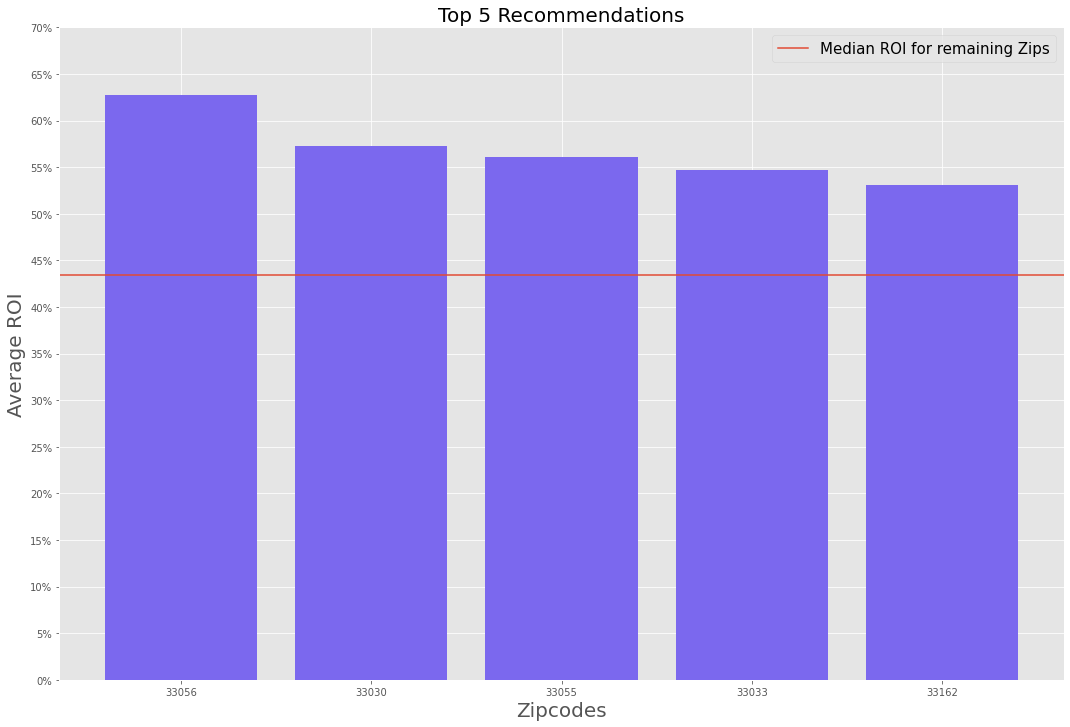

In [29]:
# Sorting our 3 year ROI forecast for zipcodes into descending order
sort_orders = sorted(zip_predictions.items(), key=lambda x: x[1], reverse=True)

sorted_forecast_3yr = {}
for i in sort_orders:
	sorted_forecast_3yr[i[0]] = i[1]

#Selecting only the Top 5 Zips
top_5_zipcodes = list(sorted_forecast_3yr.items())[:5]

fig, ax = plt.subplots(figsize=(18,12))

x_labels = [top_5_zipcodes[0][0],top_5_zipcodes[1][0],top_5_zipcodes[2][0],
            top_5_zipcodes[3][0],top_5_zipcodes[4][0]]
x = [1,2,3,4,5]
y = [top_5_zipcodes[0][1],top_5_zipcodes[1][1],top_5_zipcodes[2][1],
     top_5_zipcodes[3][1],top_5_zipcodes[4][1]]

ax.bar(x, y, color='mediumslateblue')
remaining_zipcodes = list(sorted_forecast_3yr.items())[5:]
median_ROI_other_zips = remaining_zipcodes[5][1]
ax.axhline(y=median_ROI_other_zips,label = 'Median ROI for remaining Zips')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_yticks([(a/100) for a in list(range(0,75,5))])
ax.set_yticklabels([str(a)+'%' for a in list(range(0,75,5))])
ax.set_title('Top 5 Recommendations', fontsize=20)
ax.set_ylabel('Average ROI', fontsize=20)
ax.set_xlabel('Zipcodes',fontsize=20)
ax.legend(prop={'size': 15});

In [30]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[:1][0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[:1][0][1])*100,2)}%')

The Highest Growing Zipcode: 33056 is expected to grow by 62.75%


We can see from above that our model predicts the zip-code region of 33056 to see the highest growth. But the other 4 of the top 5 zipcodes also have a forecasted ROI with encouraging returns. We can also see that our top 5 recommended zip codes are well above the median 3 year return of the remaining zip codes.

# Conclusion

Based on our work above, we can finally conclude our top 5 recommendations and their expected ROI after 3 years.

In [31]:
print(f'The Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[0][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[0][1])*100,2)}%')
print(f'The Second Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[1][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[1][1])*100,2)}%')
print(f'The Third Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[2][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[2][1])*100,2)}%')
print(f'The Fourth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[3][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[3][1])*100,2)}%')
print(f'The Fifth Highest Growing Zipcode: {list(sorted_forecast_3yr.items())[4][0]} is expected to grow by {round((list(sorted_forecast_3yr.items())[4][1])*100,2)}%')

The Highest Growing Zipcode: 33056 is expected to grow by 62.75%
The Second Highest Growing Zipcode: 33030 is expected to grow by 57.29%
The Third Highest Growing Zipcode: 33055 is expected to grow by 56.1%
The Fourth Highest Growing Zipcode: 33033 is expected to grow by 54.74%
The Fifth Highest Growing Zipcode: 33162 is expected to grow by 53.07%


After having completed our forecasting analysis, this concludes the scope of our project and therefore we leave the final investment decision on selecting one neighborhood to be made by the client based on their personal preferences. Below is a visualization of where our recommended regions are located. They are circled in red.

In [32]:
recommended_zips = pd.DataFrame([a for a in sorted_forecast_3yr.keys()][:5])
recommended_zips['latitude'] = [25.9595, 25.4803, 25.9446, 25.4921, 25.9261]
recommended_zips['longitude'] = [-80.2433, -80.5272, -80.2823, -80.4367, -80.1819]
recommended_zips.columns = ['ZipCode','Latitude','Longitude']

m = folium.Map(
    location=[25.6516,-80.4327],
    width='75%',
    length='75%',
    zoom_start=9.5
)

for a in list(range(len(recommended_zips))):
    
    folium.Circle(
    radius=4000,
    location=[recommended_zips[['Latitude','Longitude']].iloc[a][0],recommended_zips[['Latitude','Longitude']].iloc[a][1]],
    popup="The Waterfront",
    color="crimson",
    fill=True,
    ).add_to(m);

m